# LSTM Introductory Quantitative Strategy - Victor Bustos & Marcus Victor

Based on LSTM stock prediction values, we calculate 7-days futures returns, analysing SP&500 stocks and selecting the desired stocks to add to the portfolio through a 'low-volatility-momentum' strategy. We further analyze the momentum scores of the stocks using three different periods (1-month, 3-month and 6-month momentum scores), selecting a reasonable momentum threshold in accordance to the distributions of these scores. We set a maximum volatility by using a 63 days volatility window, calculating all volatilities fitting this criteria and afterwards averaging them out to a single value, for each stock. We select the stocks to be invested based upon these two criterias, attributing weights to the stocks in a decile basis: the top 10% gets bigger weights ('winners' portfolio), going down until the last 10%, with smaller weights ('losers' portfolio).

* A momentum strategy is a strategy to buy past winners and to sell
past losers. It's a bet on the ability of past returns to predict future returns - academic literature has documented evidence that momentum profits are significantly positive and pervasive across multiple time periods.

Load Data

In [1]:
from modules.load_data import load_data
import numpy as np
dict_data = load_data()

* Initial Exploratory Analysis

Stock selection process: target function to be optimized was thought out to be a weighted mean between the three momentum periods, using volatility threshold to exclude some of the stocks. Momentum threshold determined after looking at the momentum histograms - later, it may be altered.

In [2]:
log_returns = np.log(dict_data['prices']).diff().fillna(0)
returns = (dict_data['prices'].diff()/dict_data['prices'].shift(1)).fillna(0)
log_returns

Ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-03,-0.015713,-0.024751,-0.012395,-0.007648,0.000000,-0.010080,-0.030210,-0.003130,-0.005329,-0.017774,...,-0.032185,-0.001788,-0.020174,-0.004982,0.000000,-0.001293,-0.007725,-0.023279,-0.007523,0.000000
2011-06-06,-0.007787,-0.038934,-0.014782,-0.015474,0.000000,0.002678,-0.024606,-0.001569,-0.004462,-0.000673,...,0.000735,-0.010995,-0.011419,-0.024152,0.000000,-0.009750,-0.010742,-0.012576,-0.032340,0.000000
2011-06-07,0.013588,0.001240,-0.007849,-0.017700,0.000000,0.011229,0.014135,0.007299,-0.002687,0.008710,...,0.013134,-0.003625,-0.003244,-0.016624,0.000000,0.004887,-0.009978,0.003644,-0.016854,0.000000
2011-06-08,0.000642,-0.035313,-0.000375,0.000000,0.000000,0.001468,-0.002342,0.003112,-0.005396,-0.009383,...,-0.024955,0.009437,-0.000887,-0.015143,0.000000,-0.010783,-0.016139,-0.000728,0.010707,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,-0.008848,0.011009,0.024369,-0.007582,-0.007162,0.000479,0.000000,0.004248,-0.016571,-0.003424,...,0.000000,0.018289,0.022461,0.005002,-0.003248,-0.010155,-0.008229,0.032676,0.017884,-0.004942
2023-06-27,-0.011321,0.053875,0.015191,0.014947,-0.017567,0.005418,0.000000,-0.006657,-0.001124,0.011367,...,0.000000,0.002490,0.015202,0.013452,0.008458,0.000372,0.013907,0.034901,0.008091,0.018510
2023-06-28,-0.005752,0.011461,-0.003519,0.006308,-0.000679,0.004967,0.000000,-0.001671,0.007562,0.003021,...,0.000000,0.008097,-0.008332,-0.013452,-0.009633,0.006532,-0.005609,0.002402,-0.007722,-0.009242


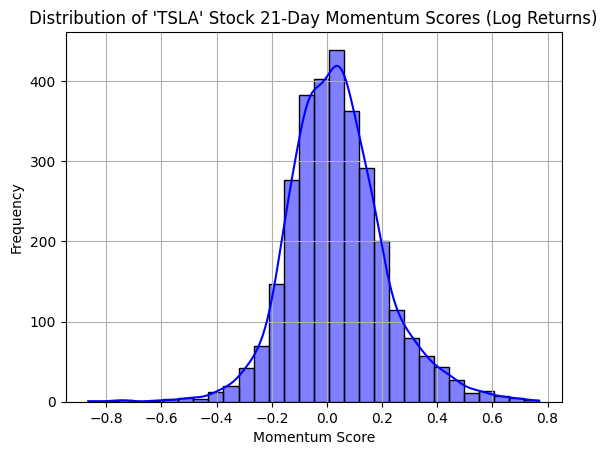

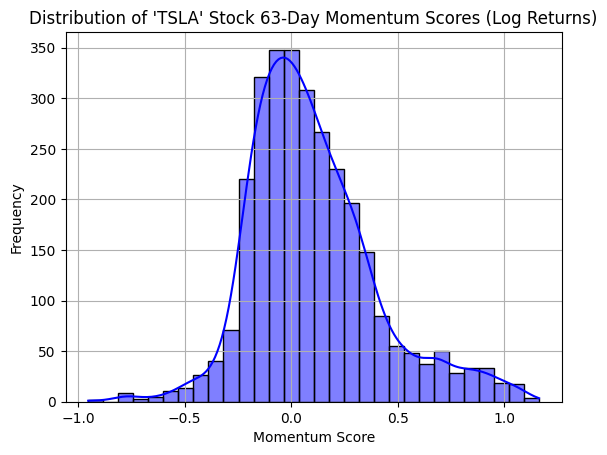

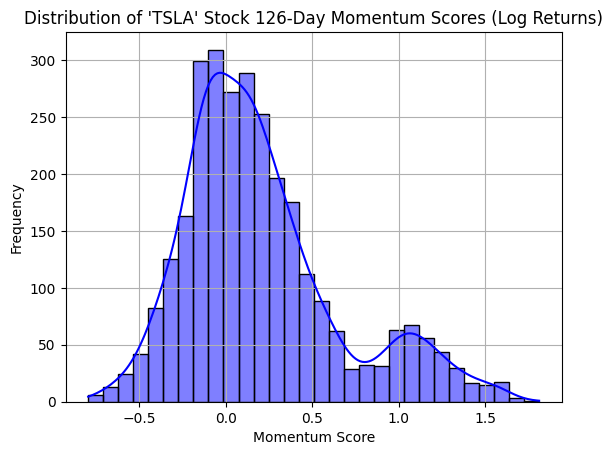

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

volatility_window = 63  # Assuming daily data

# Initialize an empty DataFrame to store momentum scores
momentum_scores_df = pd.DataFrame(index=log_returns.index)
vol_df = pd.DataFrame(index=log_returns.index)
volatilities = []
for column in log_returns:
    # Calculate the rolling standard deviation to measure mean volatility for this stock
    vol_df[f'{volatility_window}-Day Low Volatility of {column} Stock'] = log_returns[column].rolling(volatility_window).std()
    vol_values = np.nan_to_num(log_returns[column].rolling(volatility_window).std().values)
    mean_vol = np.mean(vol_values)
    volatilities.append(mean_vol)

    # Define multiple momentum periods in terms of trading days
    momentum_periods = [21, 63, 126]  # 1-month, 3-month, and 6-month

    # Calculate momentum scores for each period and store in the DataFrame
    for period in momentum_periods:
        momentum_scores = log_returns[column].rolling(period).sum()
        momentum_scores = momentum_scores.shift(-period)
        momentum_scores_df[f'{period}-Day Momentum of {column} Stock'] = momentum_scores

momentum_scores_df.fillna(0)
vol_df.fillna(0)
column = 'TSLA'
for period in momentum_periods:
    plt.figure()
    sns.histplot(momentum_scores_df[f'{period}-Day Momentum of {column} Stock'], bins=30, kde=True, color='blue', edgecolor='k')
    plt.title(f"Distribution of '{column}' Stock {period}-Day Momentum Scores (Log Returns)")
    plt.xlabel('Momentum Score')
    plt.ylabel('Frequency')
    plt.grid(True)

# Define thresholds for low volatility and momentum
low_volatility_threshold = 0.01
momentum_threshold = np.log(1.1) # 110% momentum score, in an attempt to guarantee nice stock volume with good upward prospect trend.

# Create boolean DataFrames for low volatility and momentum
low_volatility_condition = vol_df < low_volatility_threshold
momentum_condition = momentum_scores_df > momentum_threshold

# Combine the conditions to select assets
selected_assets_df = low_volatility_condition & momentum_condition

#sel_stocks = []
#for column in selected_assets_df:
#    if selected_assets_df[column].rolling(low_volatility_period).fillna(0) != 0:
#        sel_stocks.append(column)
#len(sel_stocks)

In [146]:
df = dict_data['prices']
df = df[['A', 'DXCM', 'TSLA', 'AAPL', 'MSFT']]
log_df = np.log(df).diff().fillna(0)
log_df

Ticker,A,DXCM,TSLA,AAPL,MSFT
Date,,,,,
2011-06-02,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-03,-0.015713,-0.027029,0.045810,-0.007648,-0.012672
2011-06-06,-0.007787,-0.036266,-0.051031,-0.015474,0.004242
2011-06-07,0.013588,0.000000,-0.010526,-0.017700,0.002114
2011-06-08,0.000642,-0.011429,-0.043250,0.000000,-0.005294
...,...,...,...,...,...
2023-06-26,-0.008848,-0.016948,-0.062514,-0.007582,-0.019349
2023-06-27,-0.011321,-0.009028,0.037296,0.014947,0.018005
2023-06-28,-0.005752,0.023369,0.023814,0.006308,0.003819


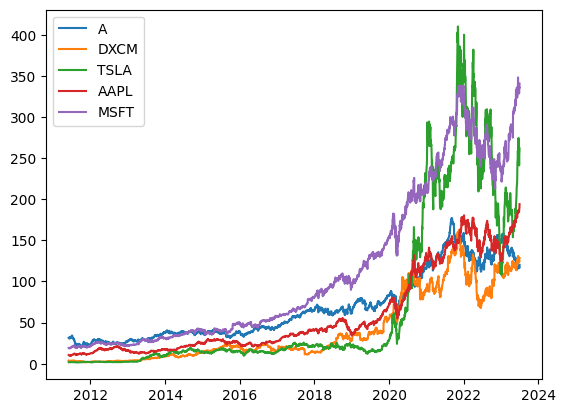

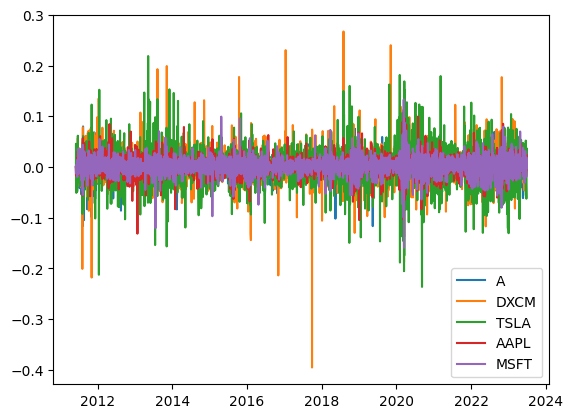

In [147]:
plt.figure(1)
plt.plot(df.index, df['A'])
plt.plot(df.index, df['DXCM'], df['TSLA'])
plt.plot(df.index, df['AAPL'], df['MSFT'])
plt.legend(['A', 'DXCM', 'TSLA', 'AAPL', 'MSFT'])

plt.figure(2)
plt.plot(log_df.index, log_df['A'])
plt.plot(log_df.index, log_df['DXCM'], log_df['TSLA'])
plt.plot(log_df.index, log_df['AAPL'], log_df['MSFT'])
plt.legend(['A', 'DXCM', 'TSLA', 'AAPL', 'MSFT'])

In [171]:
df.loc['2020-06-29']

Ticker
A        85.67
DXCM     99.55
TSLA     67.29
AAPL     88.80
MSFT    193.05
Name: 2020-06-29 00:00:00, dtype: float64

* Price prediction:

In [168]:
import datetime
import pandas as pd

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  col_name = list(dataframe.columns)[0]
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset[col_name].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df[f'Target Date of Stock {col_name}'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i} of Stock {col_name}'] = X[:, i]
  
  ret_df[f'Target of Stock {col_name}'] = Y

  return ret_df


# Start day second time around: '2021-03-25'
stocks = list(df.columns)
windowed_df_1 = df_to_windowed_df(df[['A']],
                                '2018-06-29',
                                '2020-06-29',
                                n=60)

windowed_df_2 = df_to_windowed_df(df[['DXCM']],
                                '2018-06-29',
                                '2020-06-29',
                                n=60)

windowed_df_3 = df_to_windowed_df(df[['TSLA']],
                                '2018-06-29',
                                '2020-06-29',
                                n=60)

windowed_df_4 = df_to_windowed_df(df[['AAPL']],
                                '2018-06-29',
                                '2020-06-29',
                                n=60)
                              
windowed_df_5 = df_to_windowed_df(df[['MSFT']],
                                '2018-06-29',
                                '2020-06-29',
                                n=60)

In [169]:
windowed_df_1

,Target Date of Stock A,Target-60 of Stock A,Target-59 of Stock A,Target-58 of Stock A,Target-57 of Stock A,Target-56 of Stock A,Target-55 of Stock A,Target-54 of Stock A,Target-53 of Stock A,Target-52 of Stock A,...,Target-9 of Stock A,Target-8 of Stock A,Target-7 of Stock A,Target-6 of Stock A,Target-5 of Stock A,Target-4 of Stock A,Target-3 of Stock A,Target-2 of Stock A,Target-1 of Stock A,Target of Stock A
0,2018-06-29,63.19,61.23,62.71,64.11,63.57,64.65,64.66,65.58,65.84,...,62.50,61.11,60.41,60.65,60.41,58.88,59.63,58.82,58.96,59.49
1,2018-07-02,61.23,62.71,64.11,63.57,64.65,64.66,65.58,65.84,66.91,...,61.11,60.41,60.65,60.41,58.88,59.63,58.82,58.96,59.49,59.28
2,2018-07-03,62.71,64.11,63.57,64.65,64.66,65.58,65.84,66.91,65.39,...,60.41,60.65,60.41,58.88,59.63,58.82,58.96,59.49,59.28,59.07
3,2018-07-05,64.11,63.57,64.65,64.66,65.58,65.84,66.91,65.39,64.98,...,60.65,60.41,58.88,59.63,58.82,58.96,59.49,59.28,59.07,59.60
4,2018-07-06,63.57,64.65,64.66,65.58,65.84,66.91,65.39,64.98,65.48,...,60.41,58.88,59.63,58.82,58.96,59.49,59.28,59.07,59.60,60.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2020-06-23,69.28,71.17,70.14,67.50,70.80,68.97,72.83,72.50,75.11,...,87.96,83.28,84.34,85.17,85.64,86.11,86.39,86.90,86.71,87.44
499,2020-06-24,71.17,70.14,67.50,70.80,68.97,72.83,72.50,75.11,76.72,...,83.28,84.34,85.17,85.64,86.11,86.39,86.90,86.71,87.44,84.78
500,2020-06-25,70.14,67.50,70.80,68.97,72.83,72.50,75.11,76.72,74.64,...,84.34,85.17,85.64,86.11,86.39,86.90,86.71,87.44,84.78,85.46
501,2020-06-26,67.50,70.80,68.97,72.83,72.50,75.11,76.72,74.64,77.21,...,85.17,85.64,86.11,86.39,86.90,86.71,87.44,84.78,85.46,84.13


In [161]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X1, y1 = windowed_df_to_date_X_y(windowed_df_1)
_, X2, y2 = windowed_df_to_date_X_y(windowed_df_2)
_, X3, y3 = windowed_df_to_date_X_y(windowed_df_3)
_, X4, y4 = windowed_df_to_date_X_y(windowed_df_4)
_, X5, y5 = windowed_df_to_date_X_y(windowed_df_5)

dates.shape, X2.shape, y2.shape

((503,), (503, 60, 1), (503,))

In [162]:
X1

array([[[63.19],
        [61.23],
        [62.71],
        ...,
        [59.63],
        [58.82],
        [58.96]],

       [[62.71],
        [64.11],
        [63.57],
        ...,
        [58.96],
        [59.49],
        [59.28]],

       [[64.11],
        [63.57],
        [64.65],
        ...,
        [59.49],
        [59.28],
        [59.07]],

       ...,

       [[67.5 ],
        [70.8 ],
        [68.97],
        ...,
        [87.44],
        [84.78],
        [85.46]],

       [[70.8 ],
        [68.97],
        [72.83],
        ...,
        [84.78],
        [85.46],
        [84.13]],

       [[68.97],
        [72.83],
        [72.5 ],
        ...,
        [85.46],
        [84.13],
        [85.67]]], dtype=float32)

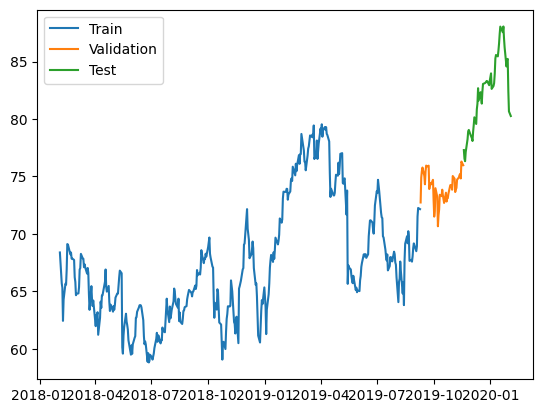

In [57]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

model = Sequential([layers.Input((120, 1)),
                    layers.LSTM(96),
                    layers.Dense(32, activation=activations.elu),
                    layers.Dense(32, activation=activations.elu),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001, epsilon=1e-8),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75)

Epoch 1/75
13/13 [==============================] - 3s 84ms/step - loss: 4279.2021 - mean_absolute_error: 65.1951 - val_loss: 4834.1875 - val_mean_absolute_error: 69.5170
Epoch 2/75
13/13 [==============================] - 1s 53ms/step - loss: 3660.2385 - mean_absolute_error: 60.2533 - val_loss: 3991.0789 - val_mean_absolute_error: 63.1624
Epoch 3/75
13/13 [==============================] - 1s 45ms/step - loss: 2765.9412 - mean_absolute_error: 52.2748 - val_loss: 2825.6665 - val_mean_absolute_error: 53.1416
Epoch 4/75
13/13 [==============================] - 1s 43ms/step - loss: 1577.5742 - mean_absolute_error: 39.0110 - val_loss: 1241.4656 - val_mean_absolute_error: 35.2113
Epoch 5/75
13/13 [==============================] - 1s 44ms/step - loss: 410.8028 - mean_absolute_error: 18.8695 - val_loss: 196.1214 - val_mean_absolute_error: 13.9459
Epoch 6/75
13/13 [==============================] - 1s 43ms/step - loss: 43.9931 - mean_absolute_error: 5.3740 - val_loss: 4.4199 - val_mean_absolu

13/13 [==============================] - 1s 20ms/step


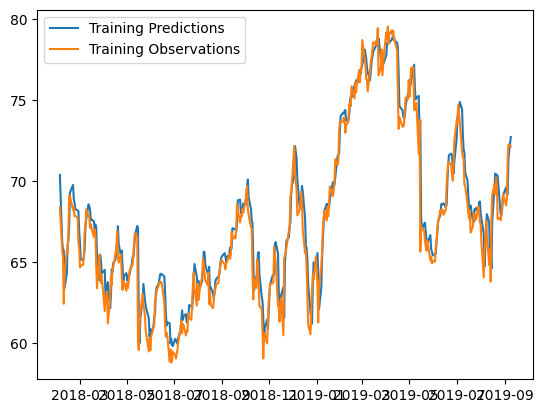

In [9]:
train_predictions = model.predict(X_train).flatten()
np.reshape(train_predictions, np.shape(dates_train))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 12ms/step


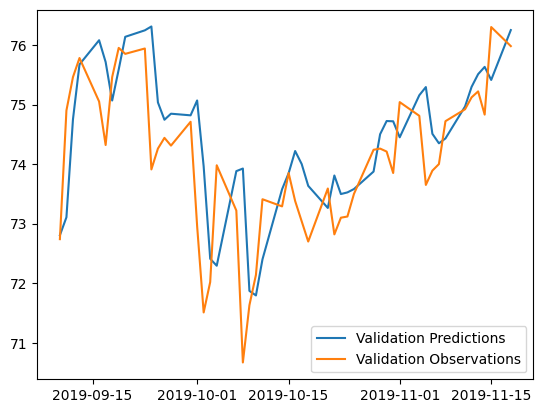

In [10]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 26ms/step


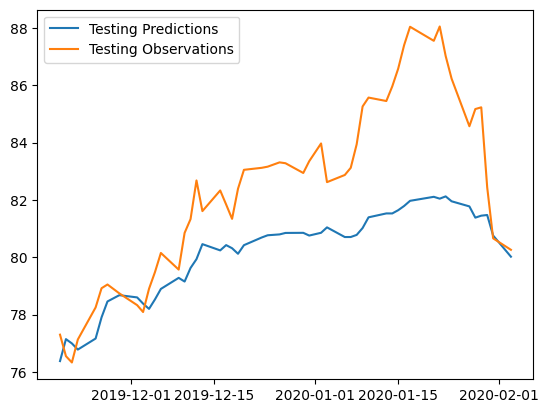

In [11]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

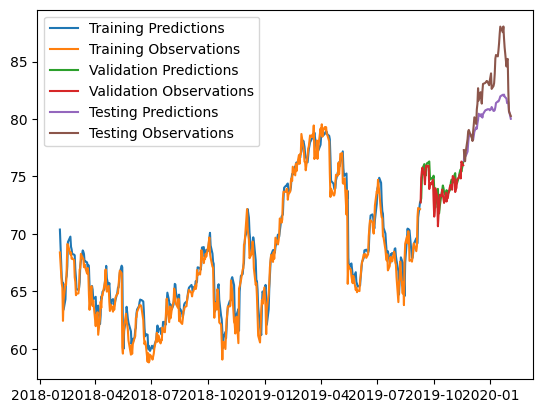

In [12]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

* Following [USMANI, S; SHAMSI, A. J; LSTM based stock prediction using weighted
and categorized financial news], a possible improvement, besides custom activation functions, varying the training & validation & testing dataset percentiles and further investigation in the number of Dense and LSTM Layers used, is compounding LSTM based stock prediction with weighted
and categorized financial news, enhancing prediction accuracy.

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window = np.concatenate([last_window[1:], [next_prediction]])

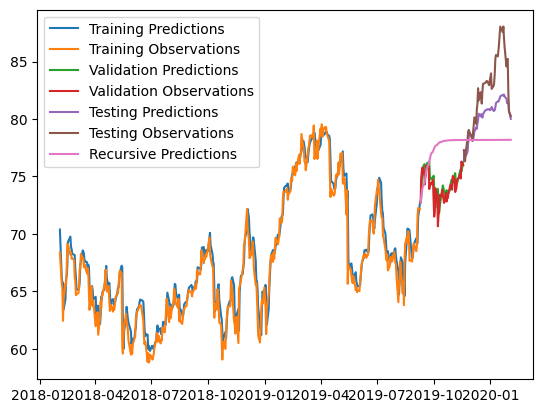

In [14]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

Simulator

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from example.lstm_strategy import lstm_strategy
from modules.strategy_simulator import strategy_simulator

# Set the path to the strategy and the strategy itself
path = "example/"  # Path to your strategy
strategy = lstm_strategy  # Your strategy

# Initialize data structures to store results
ret_port = pd.Series(dtype="float64")  # Series to store portfolio returns
weights_db = pd.DataFrame()  # DataFrame to store historical weights

# Loop through a range of time values
for t in tqdm(range(500, len(dict_data['prices'].index) - 1)):
    # Use the strategy simulator to get portfolio's historical weights [weights_db]
    # and its next day returns [ret_port]
    ret_port, weights_db = strategy_simulator(path, strategy, dict_data, t, ret_port, weights_db)
